## Rabbit Breed Image Classifition 

Task: With this project, I intend to classify four distinct rabbit breeds using a Flask app. This notebook contains the following parts of the project:
- Data Preprocessing
- CNN Model (trained from scratch)
- Model Evaluation 
- Transfer learning using pre-trained CNN model (VGG-16)
- Model Evaluation 
- Saving the Model for Inference

The notebook doesnot contain the flask app code which can be found in a separate .py file titled 'flask_app.py'.

## Dataset

![](../Images/4%20classes.jpg)



  - Source of the dataset: Google Images, Facebook Rabbit Community groups, Instagram.
  - Number of breeds included: 4
  - Number of images per breed: <br>
      California : 104 <br>
      Dutch: 108 <br>
      Holland Lop: 103 <br>
      Lionhead: 105 <br>

Images representing different breeds (serving as the data) were systematically organized and stored in four separate directories. Each directory was clearly labeled with the respective breed name to facilitate easy identification and access.

Importing libraries and dependencies

In [367]:
import os
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


Mounting Google Drive

In [332]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [368]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


Defining image size, data path, the rabbit breeds and the number of classes

In [369]:
IMG_SIZE = 100  # Defining the image size to which I want to resize
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Data-2.0'  # Path to data
BREEDS = ['California', 'Dutch', 'Holland Lop','Lionhead']  #List of Rabbit Breeds
NUM_CLASSES = 4  # Number of rabbit breeds


Initializing two empty lists, data and labels.

In [370]:
data = []
labels = []

# Pre-processing Data

In [371]:
for breed in BREEDS:  # Looping over each rabbit breed in the BREEDS list
    breed_dir = os.path.join(DATA_PATH, breed) # Creating a path to the directory for this breed
    breed_label = BREEDS.index(breed)  # Assigning a unique integer label to each breed

    for img_name in os.listdir(breed_dir):  # Iterating over each image in the breed's directory
        img_path = os.path.join(breed_dir, img_name) 
        img = cv2.imread(img_path)  # Reading the image from the file

        if img is None: # Skipping the image if it's not read correctly or is corrupted
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # Resizing the image to a standard size
        data.append(img) # Adding the image to the data list
        labels.append(breed_label) # Adding the corresponding breed label to the labels list

data = np.array(data, dtype='float32') / 255.0  # Converting the list of images to a numpy array and normalizing
labels = to_categorical(labels, num_classes=NUM_CLASSES) # Converting the list of labels to a binary class matrix

In [372]:
data.shape #cheching shape of data

(420, 100, 100, 3)

In [373]:
labels.shape #checking shape of labels

(420, 4)

In [374]:
#shuffling data
indices = np.arange(len(data))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [375]:
# Splitting the dataset
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=42)


In [376]:
train_data.shape #checking shape of training data

(378, 100, 100, 3)

In [377]:
test_data.shape #checking shape of testing data

(42, 100, 100, 3)

In [378]:
from sklearn.utils.class_weight import compute_class_weight
# Calculating class weights as the classes have different number of images
single_labels = np.argmax(train_labels, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(single_labels), y=single_labels)
class_weights_dict = dict(enumerate(class_weights))

# CNN Model

The diagram below illustrates the structure of the CNN model that I trained from scratch.

![](../Images/CNN%20Diagram.jpg)

The model structure is defined in detail below: 

- Input Layer: The network takes an input image of a rabbit of size IMG_SIZE x IMG_SIZE x 3. The '3' indicates that the image has three color channels.

- First Convolutional Layer: This layer applies 32 filters (kernels) of size 3x3 to the input image. After convolution, an activation function, ReLU (Rectified Linear Unit), is applied. The ReLU function introduces non-linearity, allowing the network to learn more complex patterns.

- First Pooling Layer: Following the first convolutional layer, there's a MaxPooling layer with a 2x2 window. MaxPooling reduces the spatial dimensions (width and height) of the input volume for the next convolutional layer. It does this by taking the maximum value over the window defined by its size (2x2 ), which helps in making the network more robust to variations in the position of features.

- Second Convolutional Layer: The next layer is another convolutional layer with 16 filters, again of size 3x3, followed by a ReLU activation function.

- Second Pooling Layer: This is another MaxPooling layer with a 2x2 window, further reducing the spatial dimensions.

- Flattening: After the second pooling, the output is flattened, converting the 2D matrix data to a 1D vector. This is necessary to transition from the convolutional layers to the fully connected layers.

- Fully Connected Layer: Following the flattening, there's a dense layer with 50 neurons and a ReLU activation function. This layer is fully connected, meaning every neuron in this layer is connected to all the neurons in the previous layer.

- Dropout Layer: There's a dropout layer with a rate of 0.5, which means during training, 50% of the nodes in the previous layer will be randomly dropped out. This is done to prevent overfitting by providing a form of regularization.

- Output Layer: Finally, the network ends with an output dense layer with a number of neurons equal to 4, which represents the number of classes the model is trying to predict. It uses the softmax activation function, which is standard for multi-class classification tasks. Softmax converts the output to probability distributions across the classes.

In [380]:

# Defining the CNN model
model = Sequential()


model.add(Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3))) #first convolutional layer
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3))) #second convolutional layer
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5)) #regularization
model.add(Dense(50, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [381]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [382]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 activation_30 (Activation)  (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 47, 47, 16)        4624      
                                                                 
 activation_31 (Activation)  (None, 47, 47, 16)        0         
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 23, 23, 16)        0         
 ng2D)                                               

Initialized early stopping to prevent the model from over-fitting the data. If the model overfits it will not be able to generalize well to unseen data. 

In [383]:
# Initialize early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
patience=2,
verbose=1,
restore_best_weights=True
)

# Training the model <br>
Selected a small batch size as it allows the model to learn from each individual example, however, it takes longer to train. A larger batch size trains faster but may result in the model not capturing the nuances in the data.


In [384]:
history = model.fit(train_data, train_labels,
epochs=200, batch_size=12,
validation_split=0.2, class_weight= class_weights_dict,
callbacks=[early_stopping])


Epoch 1/200
26/26 [==============================] - 2s 20ms/step - loss: 1.3942 - accuracy: 0.2583 - val_loss: 1.3889 - val_accuracy: 0.3553
Epoch 2/200
26/26 [==============================] - 0s 9ms/step - loss: 1.3468 - accuracy: 0.3675 - val_loss: 1.3580 - val_accuracy: 0.2895
Epoch 3/200
26/26 [==============================] - 0s 11ms/step - loss: 1.2261 - accuracy: 0.4934 - val_loss: 1.2858 - val_accuracy: 0.3289
Epoch 4/200
26/26 [==============================] - 0s 11ms/step - loss: 0.9944 - accuracy: 0.5927 - val_loss: 1.0871 - val_accuracy: 0.5395
Epoch 5/200
26/26 [==============================] - 0s 9ms/step - loss: 0.6648 - accuracy: 0.7748 - val_loss: 1.1480 - val_accuracy: 0.5526
Epoch 6/200
26/26 [==============================] - 0s 9ms/step - loss: 0.5031 - accuracy: 0.8311 - val_loss: 1.1683 - val_accuracy: 0.5395
Epoch 6: early stopping


# Model Evaluation

In [385]:
evaluation = model.evaluate(test_data, test_labels)
print(f'Test Loss: {evaluation[0]}')
print(f'Test Accuracy: {evaluation[1]}')

2/2 [==============================] - 0s 9ms/step - loss: 1.1277 - accuracy: 0.5000
Test Loss: 1.1276750564575195
Test Accuracy: 0.5


The Model is giving us a test accuracy of 50% while the loss is 1.12. Ideally want the loss to be as close to 0 as possible and the accuracy to be as high as possible. We will now look at plots of epoch vs loss and epoch vs accuracy to further understand the model behaviour. 

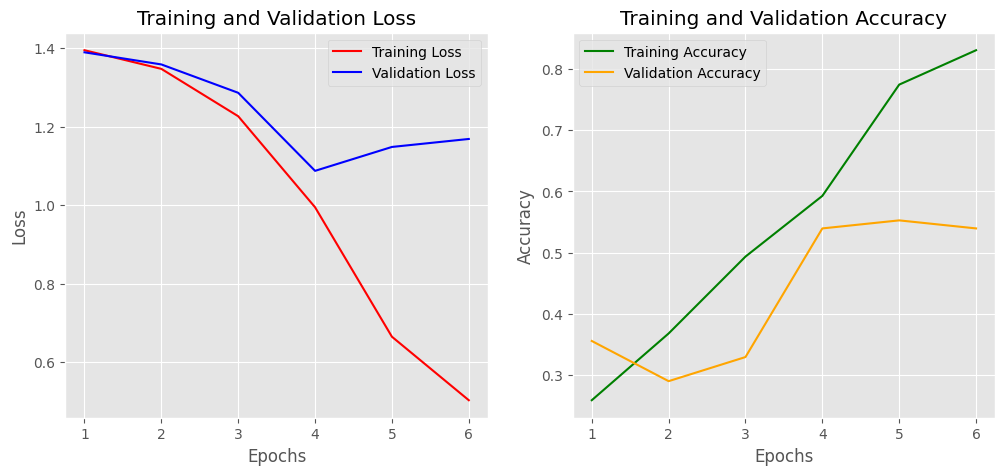

In [386]:
import matplotlib.pyplot as plt

# Plot the loss and accuracy curves for training and validation
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'g-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

 Initially, both losses decrease as the number of epochs increases, which is expected as the model learns from the data. However, after the third epoch, the validation loss increases while the training loss continues to decrease, which may indicate that the model is starting to overfit the training data. Overfitting happens when a model learns the details and noise in the training data to an extent that it negatively impacts the performance of the model on new data.

 The training accuracy consistently increases, which is good as it means the model is getting better at predicting the training data. However, the validation accuracy increases only slightly and then plateaus, suggesting that the model is not improving on the validation dataset as much as on the training dataset. We will now further test the performance of our model by plotting a confusion_matrix. 

2/2 [==============================] - 0s 5ms/step


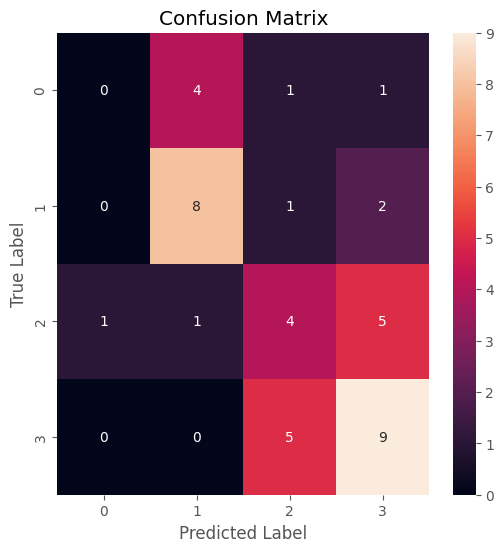

In [387]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the values from the test dataset
test_pred = model.predict(test_data)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_pred_classes)

# Plotting
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In line with the model accuracy we evaluated earlier, the model is making the right prediction for 2 classes out of 4, verfying 50% accuracy.

# Transfer learning with VGG-16 Model 

In [388]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model



In [389]:
# Load pre-trained VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))



In [390]:

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False


In [391]:
# Add custom layers on top for your specific task
x = base_model.output
x = Flatten()(x)  # Flatten the output of the base model
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(NUM_CLASSES, activation='softmax')(x)



In [392]:
# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)



In [393]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Training the new model

In [394]:
# Train the model 
history = model.fit(train_data, train_labels, epochs=20, validation_split=0.2)

Epoch 1/20
10/10 [==============================] - 2s 74ms/step - loss: 2.2159 - accuracy: 0.4007 - val_loss: 1.0230 - val_accuracy: 0.6184
Epoch 2/20
10/10 [==============================] - 0s 50ms/step - loss: 0.8652 - accuracy: 0.6589 - val_loss: 0.6221 - val_accuracy: 0.7105
Epoch 3/20
10/10 [==============================] - 0s 42ms/step - loss: 0.4721 - accuracy: 0.8212 - val_loss: 0.6183 - val_accuracy: 0.8026
Epoch 4/20
10/10 [==============================] - 0s 42ms/step - loss: 0.3052 - accuracy: 0.8940 - val_loss: 0.5550 - val_accuracy: 0.8026
Epoch 5/20
10/10 [==============================] - 0s 51ms/step - loss: 0.1802 - accuracy: 0.9503 - val_loss: 0.5396 - val_accuracy: 0.8026
Epoch 6/20
10/10 [==============================] - 0s 50ms/step - loss: 0.1392 - accuracy: 0.9636 - val_loss: 0.5408 - val_accuracy: 0.8026
Epoch 7/20
10/10 [==============================] - 0s 49ms/step - loss: 0.1136 - accuracy: 0.9768 - val_loss: 0.5580 - val_accuracy: 0.7763
Epoch 8/20
10

# Model Evaluation

In [395]:
evaluation = model.evaluate(test_data, test_labels)
print(f'Test Loss: {evaluation[0]}')
print(f'Test Accuracy: {evaluation[1]}')

2/2 [==============================] - 0s 29ms/step - loss: 0.2860 - accuracy: 0.8333
Test Loss: 0.28595423698425293
Test Accuracy: 0.8333333134651184


This model provides us an accuracy of 83% which is a marked improvement from 50% accuracy of the previous model. The loss is also close to 0 which means are model is performing better. 

In [396]:
model.save('rabbit_breeds_classifier_vgg.h5') #saving model for future inference

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


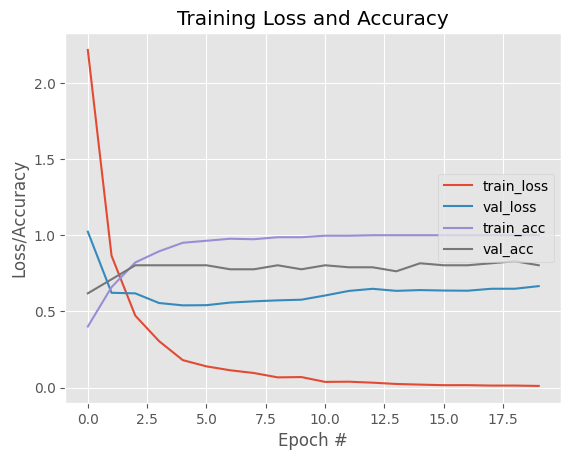

In [397]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("VGG16 Model")

After an initial sharp decrease, the training loss levels off, which is typical as the model begins to converge to a solution.  Like the training loss, validation loss decreases sharply at first and then stabilizes. However, it appears to be slightly increasing towards the later epochs, which could be a sign of overfitting, where the model performs well on the training data but is failing to generalize to unseen data.

The training accuracy seems to be quite high and stable, indicating the model performs well on the training set. The validation accuracy appears relatively stable after the initial epochs, but it does not reach the same high level as the training accuracy, which again suggests the model may not generalize as well to new data. We have however achieved a good level of accuracy and a decreased loss, so we will further evaluate our model using a confusion matrix.

2/2 [==============================] - 0s 42ms/step


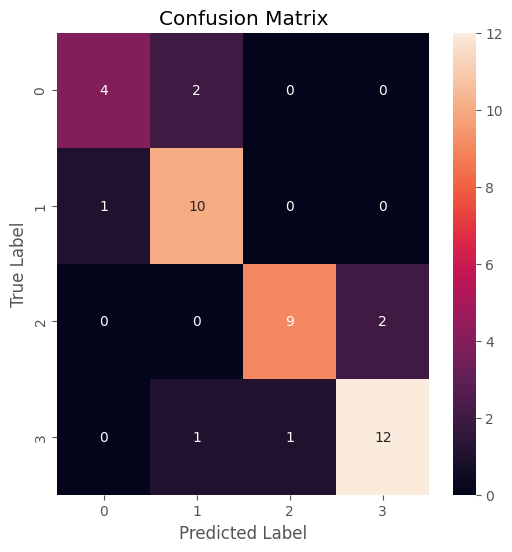

In [398]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the values from the test dataset
test_pred = model.predict(test_data)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_pred_classes)

# Plotting
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

The Model is mostly making the right predictions. Some misclassification may be expected for mixed breeds. Generally, rabbit classes can have similar patterns and may prove hard to classify, but our model is working well with an accuracy of 83% even though we had limited data to work with.